In [61]:
#import libraries to be used
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [62]:
#import cleaned crash and weather data
crash = pd.read_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/Crashes_in_DC_cleaned.csv')
weather = pd.read_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/Weather_Cleaned_Data(2015-2019).csv')

In [63]:
#looking at shape data to see how many rows and columns i should expect
#in the new data set. 128758 rows and 22 columns
crash_shape = crash.shape
weather_shape = weather.shape

print('the crash data has', crash_shape,'rows and columns')
print('the weather data has',weather_shape,'rows and columns')

the crash data has (106422, 6) rows and columns
the weather data has (1831, 16) rows and columns


In [64]:
#Removes timezone and strips the time of dat from the crash REPORTDATE
#column to prepared for the merge
crash['REPORTDATE'] = pd.to_datetime(crash['REPORTDATE'])
crash['REPORTDATE'] = crash['REPORTDATE'].dt.tz_convert(None)
crash['REPORTDATE'] = crash['REPORTDATE'].dt.strftime('%Y-%m-%d')
crash['REPORTDATE'] = pd.to_datetime(crash['REPORTDATE'])

#need to convert date time column in the weather DF so it can merge
weather['Date time'] = pd.to_datetime(weather['Date time'])


In [65]:
#merging the files on the date
merged = pd.merge(crash, weather, how = 'inner', 
                  left_on = crash['REPORTDATE'],
                  right_on = weather['Date time'])
print(merged.shape)
print(merged.columns)
print(merged.dtypes)

(106735, 23)
Index(['key_0', 'REPORTDATE', 'CrashCount', 'Hour', 'Day', 'Month', 'Year',
       'Date time', 'Maximum Temperature', 'Minimum Temperature',
       'Temperature', 'Wind Chill', 'Heat Index', 'Precipitation', 'Snow',
       'Snow Depth', 'Wind Speed', 'Wind Direction', 'Wind Gust', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'Conditions'],
      dtype='object')
key_0                  datetime64[ns]
REPORTDATE             datetime64[ns]
CrashCount                      int64
Hour                            int64
Day                             int64
Month                           int64
Year                            int64
Date time              datetime64[ns]
Maximum Temperature           float64
Minimum Temperature           float64
Temperature                   float64
Wind Chill                    float64
Heat Index                    float64
Precipitation                 float64
Snow                          float64
Snow Depth                    float64
Wi

In [66]:
#drop and rename columns
merged = merged.drop(columns = ['Date time', 'Maximum Temperature', 'Minimum Temperature', 'Wind Chill', 'Heat Index',
                               'Wind Speed', 'Wind Direction', 'Wind Gust', 'Cloud Cover','Relative Humidity', 'Temperature',
                                'Visibility', 'Conditions', 'Snow', 'Snow Depth'])
merged.columns

Index(['key_0', 'REPORTDATE', 'CrashCount', 'Hour', 'Day', 'Month', 'Year',
       'Precipitation'],
      dtype='object')

In [67]:
#grouping by date 
merged2 = merged.groupby(['Hour','Day','Month'], as_index=False).agg(
{
    'CrashCount':'count',
    'Precipitation':'mean'
})
print(merged2.dtypes)
print(merged2.shape)
merged2

Hour               int64
Day                int64
Month              int64
CrashCount         int64
Precipitation    float64
dtype: object
(8756, 5)


,Hour,Day,Month,CrashCount,Precipitation
0,0,1,1,14,0.060714
1,0,1,2,13,0.019231
2,0,1,3,19,0.247368
3,0,1,4,19,0.015789
4,0,1,5,11,0.085455
...,...,...,...,...,...
8751,23,31,5,24,0.236250
8752,23,31,7,19,0.017895
8753,23,31,8,16,0.013125
8754,23,31,10,15,0.150667


In [71]:
#dummies on hour
dummy = pd.get_dummies(merged2['Hour'])
dummy.columns = ['Hour_0','Hour_1','Hour_2','Hour_3','Hour_4','Hour_5','Hour_6','Hour_7','Hour_8','Hour_9',
                 'Hour_10','Hour_11','Hour_12','Hour_13','Hour_14','Hour_15','Hour_16','Hour_17','Hour_18',
                 'Hour_19','Hour_20','Hour_21','Hour_22','Hour_23']
#merged2 = merged2.drop(columns = ['Hour'])
merged2 = pd.concat([merged2, dummy] , axis = 1)

In [72]:
#real dummies on Day
dummy2 = pd.get_dummies(merged2['Day'])
dummy2.columns = ['Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Day_7','Day_8','Day_9','Day_10',
                  'Day_11','Day_12','Day_13','Day_14','Day_15','Day_16','Day_17','Day_18','Day_19','Day_20',
                  'Day_21','Day_22','Day_23','Day_24','Day_25','Day_26','Day_27','Day_28','Day_29','Day_30',
                  'Day_31']              
merged2 = pd.concat([merged2, dummy2] , axis = 1)
#merged2 = merged2.drop(columns = ['Month'])

In [70]:
#real dummies on month
dummy3 = pd.get_dummies(merged2['Month'])
dummy3.columns = ['Month_1', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
                 'Month_10', 'Month_11', 'Month_12']              
merged2 = pd.concat([merged2, dummy3] , axis = 1)
#merged2 = merged2.drop(columns = ['Month'])
merged2

,Hour,Day,Month,CrashCount,Precipitation,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0,1,1,14,0.060714,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,2,13,0.019231,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,19,0.247368,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,4,19,0.015789,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,5,11,0.085455,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,23,31,5,24,0.236250,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8752,23,31,7,19,0.017895,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8753,23,31,8,16,0.013125,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8754,23,31,10,15,0.150667,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [78]:
merged['Precipitation_indicator'] = merged.where(merged['Precipitation'] != 0, 1)
merged

ValueError: Wrong number of items passed 8, placement implies 1

In [73]:
#real dummies on precipitaion
dummy2 = pd.get_dummies(merged2['Precipitation_Dummy'])
dummy2.columns = ['Precipitation', 'No_Precipitation']
merged2 = pd.concat([merged2, dummy2] , axis = 1)
merged2 = merged2.drop(columns = ['Precipitation_Dummy'])

KeyError: 'Precipitation_Dummy'

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

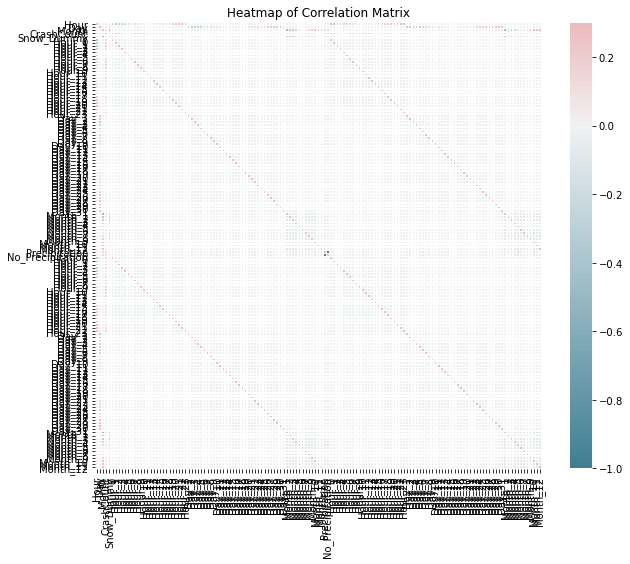

In [29]:
# Heatmap of features
corr = merged2.corr()
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [ ]:
#histogram for Crashs
x = merged2['CrashCount']
num_bins = 38
plt.hist(x, num_bins, facecolor='pink', alpha=0.5, ec='black')

plt.xlabel('Bins')
plt.ylabel('Number of Crashes')
plt.title('Car Crash Distribution', fontsize = 15)

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(merged2['CrashCount'])

In [ ]:
#histogram for month
x = merged2['Month']
num_bins = 12
plt.hist(x, num_bins, facecolor='green', alpha=0.5, ec='black')

plt.xlabel('Month')
plt.ylabel('Number of Month')
plt.title('Number of Car Crashes per Month', fontsize = 15)

plt.show()

In [ ]:
#histogram for month
x = merged2['Day']
num_bins = 31
plt.hist(x, num_bins, facecolor='Orange', alpha=0.5, ec='black')

plt.xlabel('Month')
plt.ylabel('Number of Month')
plt.title('Number of Car Crashes per Month', fontsize = 15)

plt.show()

In [16]:
#export dataset to csv
merged2.to_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/merged.csv',
             index= False)